# Getting Started

This notebook outlines the best operating practices for mapping a given quantum circuit to real IBM backends. As an example, we'll use the problem statement from [this manuscript](https://arxiv.org/abs/2108.09197), quantum simulation of an Ising model Hamiltonian:
$$
H = -J \sum_{\langle i,j \rangle} Z_i Z_j + h \sum_i X_i
$$
where $J$ is the exchange coupling between adjacent spins and $h$ is the transverse magnetic field. Here $X_i$ and $Z_j$ are the Pauli matrices acting on qubits $i$ and $j$, respectively.

In [32]:
from qiskit import transpile
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.opflow import I, X, Z, PauliTrotterEvolution, Suzuki
from qiskit.test.mock import FakeMumbai

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [21]:
num_spins = 3

JJ = Parameter('J')
hh = Parameter('h')
tt = Parameter('t')

ham = - JJ*sum([sum([(I^idx)^Z^(I^jdx)^Z^(I^(num_spins-idx-jdx-2)) for jdx in range(num_spins-idx-1)])
                for idx in range(num_spins-1)]) \
      + hh*sum([(I^idx)^X^(I^(num_spins-idx-1)) for idx in range(num_spins)])
U_ham = (ham*tt).exp_i()
print(U_ham)

e^(-i*1.0*t * SummedOp([
  -1.0*J * (
    1.0 * ZZI
    + 1.0 * ZIZ
    + 1.0 * IZZ
  ),
  1.0*h * (
    1.0 * XII
    + 1.0 * IXI
    + 1.0 * IIX
  )
]))


Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


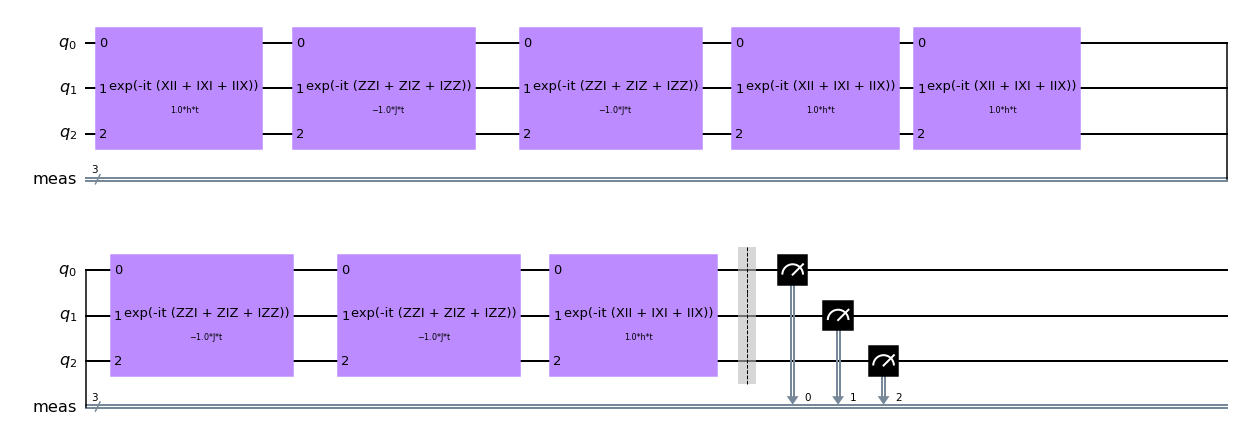

In [22]:
num_steps = 2
trot_circ = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=num_steps)).convert(U_ham).to_circuit()
trot_circ.measure_all()
trot_circ.draw('mpl')

## Transpile for Good SWAP Mapping

While the Ising Hamiltonian is a nearest-neighbor interaction, in general problems must respect the layout of the actual quantum hardware. Due to limited connectivity, this often entails doing SWAP operations to move quantum information around. SWAPs are costly in the sense they consist of three `CX`s. The Qiskit transpiler with `optimization_level=3` uses the SABRE SWAP method, which is efficient, however stochastic, since the SWAP-mapping problem is NP-hard. 

This operation serves only to minimize the number of SWAPs in the transpiled circuits, and is not aware of noise on the underlying qubits. This is considered in a following step.

In [23]:
# TODO - check issue with floats not being rounded off

num_tries = 10

backend = FakeMumbai()
trot_circ_ts = transpile([trot_circ]*num_tries, backend, optimization_level=3, seed_transpiler=12345)
cx_counts = [trot_circ_ts[idx].count_ops()['cx'] for idx in range(num_tries)]
print(cx_counts)

[98, 98, 98, 98, 98, 98, 98, 98, 98, 98]


In [26]:
best_idx = np.argmin(cx_counts)
trot_circ_t = trot_circ_ts[best_idx]

Due to the nearest-neighbor structure of this problem, the number of `CX`s is unaffected by the stochastic nature of the SWAP mapper, however, this is not true in general.

Now that we have a SWAP-mapped optimal circuit, we consider the layouts on the actual quantum backend. This process "deflates" the circuit (by removing idle qubits) and scores different layouts due to error rates, which are calculated by a cost function that considers gate error rates and $T_1$/$T_2$ times by default.

In [16]:
from mapomatic import deflate_circuit, evaluate_layouts, matching_layouts

trot_circ_def = deflate_circuit(trot_circ_t)
layouts = matching_layouts(trot_circ_def, backend)
scored_layouts = evaluate_layouts(trot_circ_def, layouts, backend)
print(scored_layouts)

[([19, 22, 26, 25], 0.29763310117296804), ([26, 25, 19, 22], 0.29815027396118354), ([25, 22, 20, 19], 0.3005778703170411), ([20, 19, 25, 22], 0.3011974362220382), ([18, 15, 10, 12], 0.3039768294246339), ([10, 12, 18, 15], 0.3057505183157796), ([19, 22, 24, 25], 0.31213774404386063), ([24, 25, 19, 22], 0.3161802927530243), ([15, 12, 7, 10], 0.31695448770764023), ([4, 7, 12, 10], 0.3179906759682847), ([7, 10, 15, 12], 0.3185779076970251), ([12, 10, 4, 7], 0.3195464257976147), ([12, 15, 17, 18], 0.3214029652924195), ([12, 15, 21, 18], 0.3265740676802177), ([17, 18, 12, 15], 0.3274770233964551), ([21, 18, 12, 15], 0.33381319222529315), ([16, 14, 8, 11], 0.3376778384318848), ([13, 14, 8, 11], 0.3389816091371799), ([8, 11, 16, 14], 0.3493489778752942), ([8, 11, 13, 14], 0.3503173711299543), ([11, 14, 12, 13], 0.36229564932900105), ([18, 15, 13, 12], 0.3640524092743953), ([16, 14, 12, 13], 0.3680122593008949), ([26, 25, 23, 24], 0.3769190387431197), ([12, 13, 11, 14], 0.37923308278991585), ([

## Pulse Scaling

The next method is particularly suited to problems in quantum simulation because the Trotterization of the unitary evolution operator `U_ham` involved interactions that are typically much smaller than the angle $\pi/2$ used to generate a `CX` from an `RZXGate`, which itself is close to what the [cross resonance entangling](https://arxiv.org/abs/1603.04821) achieves. 

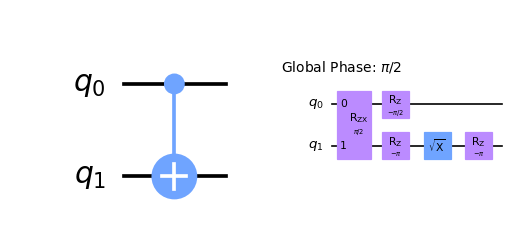

In [37]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc_rzx = transpile(qc, basis_gates=['sx','rz','rzx'])

fig, (ax1, ax2) = plt.subplots(1, 2)
qc_cx.draw('mpl', ax=ax1)
qc_rzx.draw('mpl', ax=ax2)

Since we are implementing two-qubit rotation angles less than $\pi/2$, we can more efficiently express these interaction in terms of $R_{ZX}(\theta)$ rotations and directly build them from scaled cross resonance pulses obtained from the backend, as detailed in [this manuscript](http://arxiv.org/abs/2012.11660). This method first uses a greedy algorithm called [template opimization](http://arxiv.org/abs/1909.05270) to identify parts of the circuit that can be substituted by $R_{ZX}$ rotations. If parameters are passed to the method, it will bind them to the circuit and attach the necessary pulse gates for implementing the $R_{ZX}$ rotations. Below we will do that separately, because we will attach a series of `Parameter`s as a function of time, and it is more efficient to do the template optimization step once since it is greedy and attaching the pulse schedules in quick.

In [29]:
from qiskit_research.utils.convenience import scale_cr_pulses

my_layout = scored_layouts[0][0]
trot_circ_sca = scale_cr_pulses(transpile(trot_circ_def, initial_layout=my_layout), backend)
trot_circ_sca.draw('mpl')

KeyboardInterrupt: 

In [ ]:
from qiskit_research.utils.convenience import attach_cr_pulses

t_range = np.linspace(0, 10, 51)
param_bind = {JJ: 0.5236, hh: 1}

circs = []
for t_set in t_range:
    param_bind[tt] = t_set
    circs.append(attach_cr_pulses(trot_circ_sca, backend, param_bind))

## Pauli Twirling

## Dynamical Decoupling

## Circuit Execution

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

# Set the "sampler" program inputs
inputs = {
    'circuits': circs,
    'circuit_indices': list(range(len(circs)))
}

# Configure backend options
options = {'backend_name': "ibmq_qasm_simulator"}

# Execute the circuit using the "sampler" program.
job = service.run(program_id="sampler", options=options, inputs=inputs)

In [ ]:
counts = backend.run(circs).result().get_counts()

In [53]:
backend.configuration().max_experiments

900

In [52]:
conf.max_experiments

900

In [ ]:
from qiskit.providers.ibmq.managed import IBMQJobManager

# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set_foo = job_manager.run(circs, backend=backend, name='foo')

In [ ]:
retrieved_foo = job_manager.retrieve_job_set(job_set_id=job_set_id, provider=provider)

## Measurement Error Mitigation

In [45]:
from mthree import M3Mitigation

mit = M3Mitigation(backend)
mit.cals_from_system(my_layout)

NameError: name 'my_layout' is not defined

In [44]:
quasi_probs = mit2.apply_correction(counts, my_layout)

<FakeMumbai('fake_mumbai')>